In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from cavity_solver import solve_flow
from UNet3 import UNet, conv_loss


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from samples import get_samples, get_training_data
from torch.utils import data
import time
from dask import delayed

import os

gpu_no = '0' # or '1'
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_no

In [3]:
dtype = torch.cuda.FloatTensor
filename = 'NScavityFlow_withpartial.pth'

unet = UNet(dtype, img_size=32).type(dtype)
#     print(unet)
optimizer = optim.Adam(unet.parameters(), lr = 2e-5)
checkpoint = torch.load(filename)
unet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
unet.eval()


UNet(
  (encoding_layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (encoding_BN): ModuleList(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoding_layers): ModuleList(
    (0): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride

In [4]:
class CavityFlowDataset(data.Dataset):
    """Characterizes the cavity flow dataset for training. """
    
    def __init__(self, root_dir, flowfile):
        'Initialization'
        self.flowdata = torch.load(root_dir + flowfile)

    def __len__(self):
        'Denotes the total number of samples'
        return self.flowdata.size()[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        X = self.flowdata[index]
        return X

In [4]:
import pickle
unet_partial = pickle.loads(pickle.dumps(unet))

In [5]:
# Continue training on previous model
flow_dataset = CavityFlowDataset(root_dir='./', flowfile = 'FlowData_UV_0210_warm_partial.pt')
dataloader = data.DataLoader(flow_dataset, batch_size = 16,
                        shuffle=True, num_workers=2)
# ## TEST DATA LOADING AND TRAINING 0130
dtype = torch.cuda.FloatTensor
get_loss = conv_loss(dtype = dtype)
# unet = UNet(dtype = dtype, img_size=32).type(dtype)
# optimizer = optim.Adam(unet.parameters(), lr = 2e-5)

for epoch in range(0,80000):
    for S in dataloader:
        img = S.requires_grad_(True).type(dtype)
        output = unet(img)
#         print(get_loss(img, img))
        loss = get_loss(img.detach(), output)
#         print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("epoch ", epoch, "loss ", float(loss.detach()))
#     loss_hist.append(float(loss.detach()))
    del loss

epoch  0 loss  0.011551492847502232


KeyboardInterrupt: 

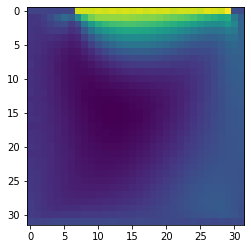

In [6]:
plt.imshow(output[1,0,:,:].detach().cpu().numpy())

In [5]:
S = torch.load('FlowData_UV_0210_warm_partial.pt')
img = S.type(dtype)
output = unet(img).type(dtype)

get_loss = conv_loss(dtype = dtype)
get_loss(img.detach(), output)

tensor(0.0130, device='cuda:0', grad_fn=<AddBackward0>)

In [15]:
del loss

In [47]:
unet.to("cuda:0")

UNet(
  (encoding_layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (encoding_BN): ModuleList(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoding_layers): ModuleList(
    (0): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride

torch.Size([16, 3, 32, 32])
U0 is:  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01515152 0.01515152 0.01515152 0.01515152 0.         0.
 0.         0.        ]
V0 is:  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.14646465 0.14646465 0.14646465 0.14646465 0.         0.
 0.         0.        ]
tensor(0.0130, device='cuda:0', grad_fn=<AddBackward0>)


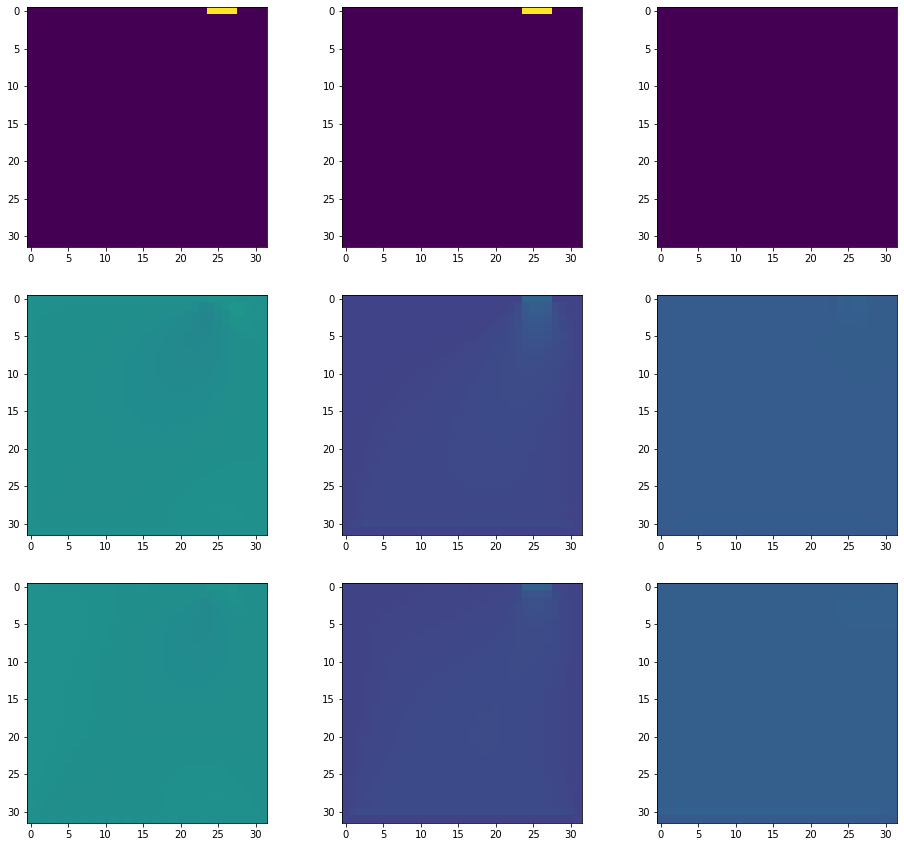

In [8]:
S = torch.load('FlowData_UV_0210_warm_partial.pt')
unet.eval()
img = S[0:16].type(dtype)
N = 1
output = unet(img)
print(output.size())
UMAX, UMIN = 0.5, -0.5
VMAX, VMIN = 1.0, -0.25
PMAX, PMIN = 6.5, -2.5
print("U0 is: ", img[N,0,0,:].detach().cpu().numpy())
u0 = img[N,0,0,:].detach().cpu().numpy()
print("V0 is: ", img[N,1,0,:].detach().cpu().numpy())
v0 = img[N,1,0,:].detach().cpu().numpy()
size = 32
u = np.zeros((size, size))
v = np.zeros((size, size))
p = np.zeros((size, size)) 
L = 1 # dimensionless LX / LX
H = 1 # dimensionless LY / LX
dx = L / (size - 1)
dy = H / (size - 1)
CFL = 0.04
dt = CFL * min(dx , dy)
RE = 20
sol_u, sol_v, sol_p = solve_flow(5000, size, size, u, v, dt, dx, dy, p, u0=u0, v0=v0 )
fig1, axes = plt.subplots(3, 3, figsize = (16,15))
axes[0,0].imshow(img[N,0,:,:].detach().cpu().numpy())
axes[0,1].imshow(img[N,1,:,:].detach().cpu().numpy())
axes[0,2].imshow(img[N,2,:,:].detach().cpu().numpy())

axes[1,0].imshow(sol_u, vmin=UMIN, vmax=UMAX)
axes[1,1].imshow(sol_v, vmin=VMIN, vmax=VMAX)
axes[1,2].imshow(sol_p, vmin=PMIN, vmax=PMAX)


axes[2,0].imshow(output[N,0,:,:].detach().cpu().numpy(), vmin=UMIN, vmax=UMAX)
axes[2,1].imshow(output[N,1,:,:].detach().cpu().numpy(), vmin=VMIN, vmax=VMAX)
axes[2,2].imshow(output[N,2,:,:].detach().cpu().numpy(), vmin=PMIN, vmax=PMAX)


print(get_loss(img,output))
del img, output
# fig1.savefig("0206Warm_example_03.png")

In [175]:
get_loss(img,output)

NameError: name 'img' is not defined

In [26]:
fig1.savefig("Partial_example_03.png")

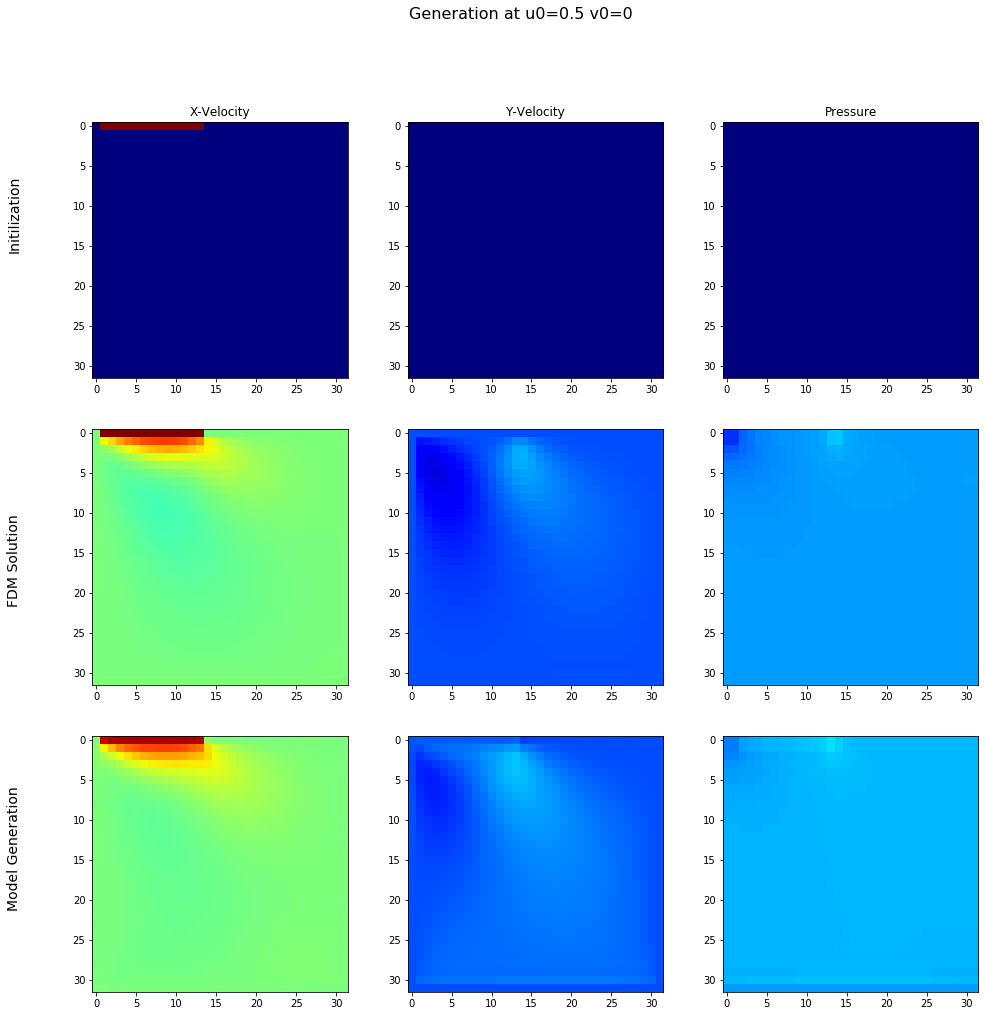

In [22]:
plt.rcParams['image.cmap'] = 'jet'

size = 32
u = np.zeros((size, size))
v = np.zeros((size, size))
p = np.zeros((size, size))
u0 = 0.5
v0 = 0
u0_vector = np.zeros((1,size))
v0_vector = np.zeros((1,size))
u0_vector[0, 1:14] = u0  
v0_vector[0, 1:32] = v0  

testUsol, testVsol, testPsol = solve_flow(1000, 32, 32, u, v, dt, dx, dy, p, u0=u0_vector, v0=v0_vector)

u = np.zeros((size, size))
v = np.zeros((size, size))
p = np.zeros((size, size)) 
iniU, iniV, iniP = solve_flow(1, 32, 32, u, v, dt, dx, dy, p, u0=u0_vector, v0=v0_vector)

warmS = torch.zeros(1, 3, 32, 32).type(dtype)
warmS[0,0,:,:] = torch.from_numpy(iniU)
warmS[0,1,:,:] = torch.from_numpy(iniV)
warmS[0,2,:,:] = torch.from_numpy(iniP)

# warmS[1:] = img[1:]
# print(warmS)

# unet.eval()

testoutput = unet(warmS).type(dtype)


fig2, axes = plt.subplots(3, 3, figsize = (16,16))

UMAX, UMIN = 0.5, -0.5
VMAX, VMIN = 1.0, -0.25
PMAX, PMIN = 6.5, -2.5


axes[0,0].imshow(warmS[0,0,:,:].detach().cpu().numpy())
axes[0,0].set_title("X-Velocity") 
axes[0,1].imshow(warmS[0,1,:,:].detach().cpu().numpy())
axes[0,1].set_title("Y-Velocity")
axes[0,2].imshow(warmS[0,2,:,:].detach().cpu().numpy())
axes[0,2].set_title("Pressure") 

axes[1,0].imshow(testUsol, vmin=UMIN, vmax=UMAX)
axes[1,1].imshow(testVsol, vmin=VMIN, vmax=VMAX)
axes[1,2].imshow(testPsol, vmin=PMIN, vmax=PMAX)


axes[2,0].imshow(testoutput[0,0,:,:].detach().cpu().numpy(), vmin=UMIN, vmax=UMAX)
axes[2,1].imshow(testoutput[0,1,:,:].detach().cpu().numpy(),vmin=VMIN, vmax=VMAX)
axes[2,2].imshow(testoutput[0,2,:,:].detach().cpu().numpy(),vmin=PMIN, vmax=PMAX)


fig2.text(0.06, 0.25, 'Model Generation', fontsize=14, ha='center', va='center', rotation='vertical')
fig2.text(0.06, 0.5, 'FDM Solution', fontsize=14, ha='center', va='center', rotation='vertical')
fig2.text(0.06, 0.8, 'Initilization', fontsize=14, ha='center', va='center', rotation='vertical')
fig2.suptitle('Generation at u0={} v0={}'.format(u0,v0), fontsize=16)
fig2.savefig("0506_cold_partial.png")

In [363]:
get_loss(warmS, testoutput)

tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)

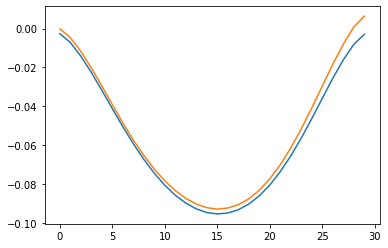

In [16]:
Solution = torch.zeros(1,3,32,32).type(dtype)

Solution[0,0,:,:] = torch.from_numpy(testUsol)
Solution[0,1,:,:] = torch.from_numpy(testVsol)
Solution[0,2,:,:] = torch.from_numpy(testPsol)
plt.plot( Solution[0,0,16,1:-1].cpu().detach().numpy() )
plt.plot( 1.2*testoutput[0,0,16,1:-1].cpu().detach().numpy() )
plt.savefig("0506_cold_cavity_center2.png")

In [364]:
fig2.savefig('0212complete_pen.png')

In [295]:
torch.abs( (testoutput[0,0,1:-1,1:-1] - Solution[0,0,1:-1,1:-1]) ) 

tensor([[2.7076e-02, 3.9534e-02, 3.9522e-02, 2.8121e-02, 1.9735e-02, 1.1945e-02,
         6.1950e-03, 2.9372e-03, 2.1015e-03, 5.1654e-03, 7.4519e-03, 1.2013e-02,
         1.4435e-02, 1.4798e-02, 1.4703e-02, 1.6412e-02, 1.7825e-02, 1.9745e-02,
         2.0517e-02, 2.2773e-02, 2.2579e-02, 2.1564e-02, 2.0232e-02, 1.8218e-02,
         1.6232e-02, 1.3818e-02, 3.0257e-03, 7.5291e-04, 2.4134e-02, 5.5663e-02],
        [4.5879e-02, 5.9547e-02, 5.9369e-02, 5.2773e-02, 4.5247e-02, 3.8293e-02,
         3.1550e-02, 2.5454e-02, 1.8632e-02, 1.4253e-02, 1.0021e-02, 5.0187e-03,
         1.6155e-03, 3.9116e-04, 2.6762e-03, 4.3963e-03, 6.3373e-03, 8.5032e-03,
         1.0919e-02, 1.3287e-02, 1.3156e-02, 1.2900e-02, 1.2202e-02, 1.1062e-02,
         9.0358e-03, 4.5027e-03, 6.1874e-03, 1.2464e-02, 2.5286e-02, 3.3042e-02],
        [4.0890e-02, 5.4785e-02, 5.9666e-02, 5.9870e-02, 5.6113e-02, 5.0982e-02,
         4.4926e-02, 3.9430e-02, 3.4161e-02, 2.8368e-02, 2.2967e-02, 1.7941e-02,
         1.4172e-02, 1.134

In [331]:
A  = []
for k in range(2048):
    A.append( (S[k,0,0,:].numpy().max()) )

(array([187., 222., 218., 204., 210., 206., 194., 226., 197., 184.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ],
       dtype=float32),
 <a list of 10 Patch objects>)

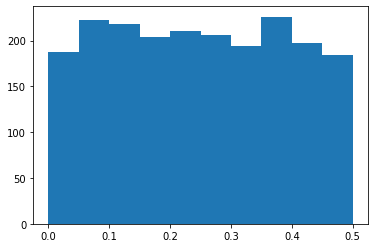

In [332]:
plt.hist(A)

In [45]:
torch.save({
                'epoch': epoch,
                'model_state_dict': unet.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'NScavityFlow_withpartial.pth')